# Analyze Participants' Answers in Pilot 2 Study

In [42]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import Lasso
from ast import literal_eval
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import utils
from params import phase_2_statements
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [43]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_2 where submit_time>='2024-03-01';"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df["pilot_2_answers"] = df["pilot_2_answers"].map(literal_eval)
df['submit_time'] = pd.to_datetime(df['submit_time'])
df = df.loc[df["participantId"] != "testId"]
df.head()

2024-03-06 14:06:01,939| ERROR   | Password is required for key /Users/guodawei/.ssh/id_rsa


Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 10


,participantId,assignmentId,projectId,attention_passed,total_time,pilot_2_answers,ideology_label,bot_detected,submit_time,identity_choices,ideologies,reason
0,02005180DD3F429DB8D8609BD1BAA324,ab515b89-f74f-4327-bd52-6e4193498df9,464ae45d-fe95-4a79-a013-b4270d3e1513,1,194.179,"[{'type': 'prediction', 'index': 4, 'answer': ...",-1.0,None,2024-03-04 01:59:06,None,None,None
1,03F53C2027DA4B6A97B25800E417927B,a7d21b2f-1050-4334-b568-1e0e028e6d90,464ae45d-fe95-4a79-a013-b4270d3e1513,1,242.079,"[{'type': 'fact', 'index': 8, 'answer': '0'}, ...",-1.0,None,2024-03-04 02:03:45,None,None,None
2,1F5DDBF00F4D432EB58F3ADD132ECCD1,cdb1a2a3-758a-4dcb-a0cf-d7c46362d27d,464ae45d-fe95-4a79-a013-b4270d3e1513,1,210.197,"[{'type': 'issue', 'index': 0, 'answer': '0'},...",-2.0,None,2024-03-04 01:58:25,None,None,None
3,37C1B21F68CF4310B47212CFB916512F,3627b44c-bc0d-47e9-bbd0-e5b0b60ba8dd,464ae45d-fe95-4a79-a013-b4270d3e1513,1,443.800,"[{'type': 'issue', 'index': 5, 'answer': '0'},...",-1.0,None,2024-03-04 02:02:34,None,None,None
4,58044DE6551C44B1B837C00135980489,689b3cc9-c5f5-4e1d-80be-ba2e1fe26aac,464ae45d-fe95-4a79-a013-b4270d3e1513,1,349.110,"[{'type': 'fact', 'index': 2, 'answer': '0'}, ...",1.0,None,2024-03-04 02:02:27,None,None,None


In [49]:
ids_attention_failed = df.loc[df['attention_passed'] == 0]["participantId"].tolist()
print(f"Participants who failed attention check: {ids_attention_failed}")
df = df.loc[df["attention_passed"] == 1]
df = df.loc[:, ["participantId", "pilot_2_answers", "ideology_label"]].set_index("participantId")

def IdeologyToNumber(ideology):
    if ideology == "Moderate":
        return 0
    elif ideology == "Somewhat Conservative":
        return 1
    elif ideology == "Conservative":
        return 2
    elif ideology == "Somewhat Liberal": 
        return -1
    elif ideology == "Liberal":
        return -2

# connect_data_csv = glob.glob('data/connect_raw_data/pilot-2-2*.csv')[0]
# df_connect = pd.read_csv(connect_data_csv).set_index("ParticipantId")
# df["connect_ideology"] = df_connect["Political Ideology"].map(IdeologyToNumber)
# print("rmse of ideology:", np.sqrt(np.mean((df["ideology_label"] - df["connect_ideology"])**2)))
df["ideology"] = df["ideology_label"]
df.drop(["ideology_label"], axis=1, inplace=True)
# df.drop(["connect_ideology", "ideology_label"], axis=1, inplace=True)
df.head()

KeyError: 'attention_passed'

In [88]:
import os
from pathlib import Path
import re
import json

folder_path = Path(os.getcwd())
pilot_2_statements_js = folder_path.parent / "app"/ "static" / "data" / "phase_2_statements.js"
with open(pilot_2_statements_js) as js:
    js_content = js.read()
    json_content = js_content.replace("\n", "").replace("/'", "'")
    json_content = json_content.lstrip("const phase_2_statements = ")
phase_2_statements = json.loads(json_content)

## 1. The Answer Patter for Each Question

In [113]:
df_exploded = df.explode(["pilot_2_answers"])
df_each = df_exploded["pilot_2_answers"].apply(pd.Series)
df_each = pd.concat([df_each, df_exploded], axis=1)
df_each = df_each.reset_index()
df_each.drop(["pilot_2_answers", "participantId"], axis=1, inplace=True)
print(df_each.groupby(["type", "index"]).size())
df_each = df_each.set_index(["type", "index"])
df_each = df_each.astype({"answer": int})
df_each.head()

type        index
design      0        4
            1        4
            2        1
            3        3
            4        5
            5        3
            6        5
            7        5
            8        3
            9        5
            10       7
            11       5
            12       5
fact        0        4
            1        6
            2        4
            3        5
            4        4
            5        6
            6        5
            7        6
            8        5
            9        2
            10       5
            11       5
            12       5
            13       1
issue       0        7
            1        5
            2        6
            3        5
            4        6
            5        2
            6        7
            7        6
            8        1
            9        5
            10       5
            11       3
            12       6
            13       7
            14       5
prediction  0   

,,answer,ideology
type,index,,
prediction,4,0,-1.0
fact,8,0,-1.0
prediction,1,0,-1.0
design,11,1,-1.0
fact,1,1,-1.0


ValueError: x and y must have length at least 2.

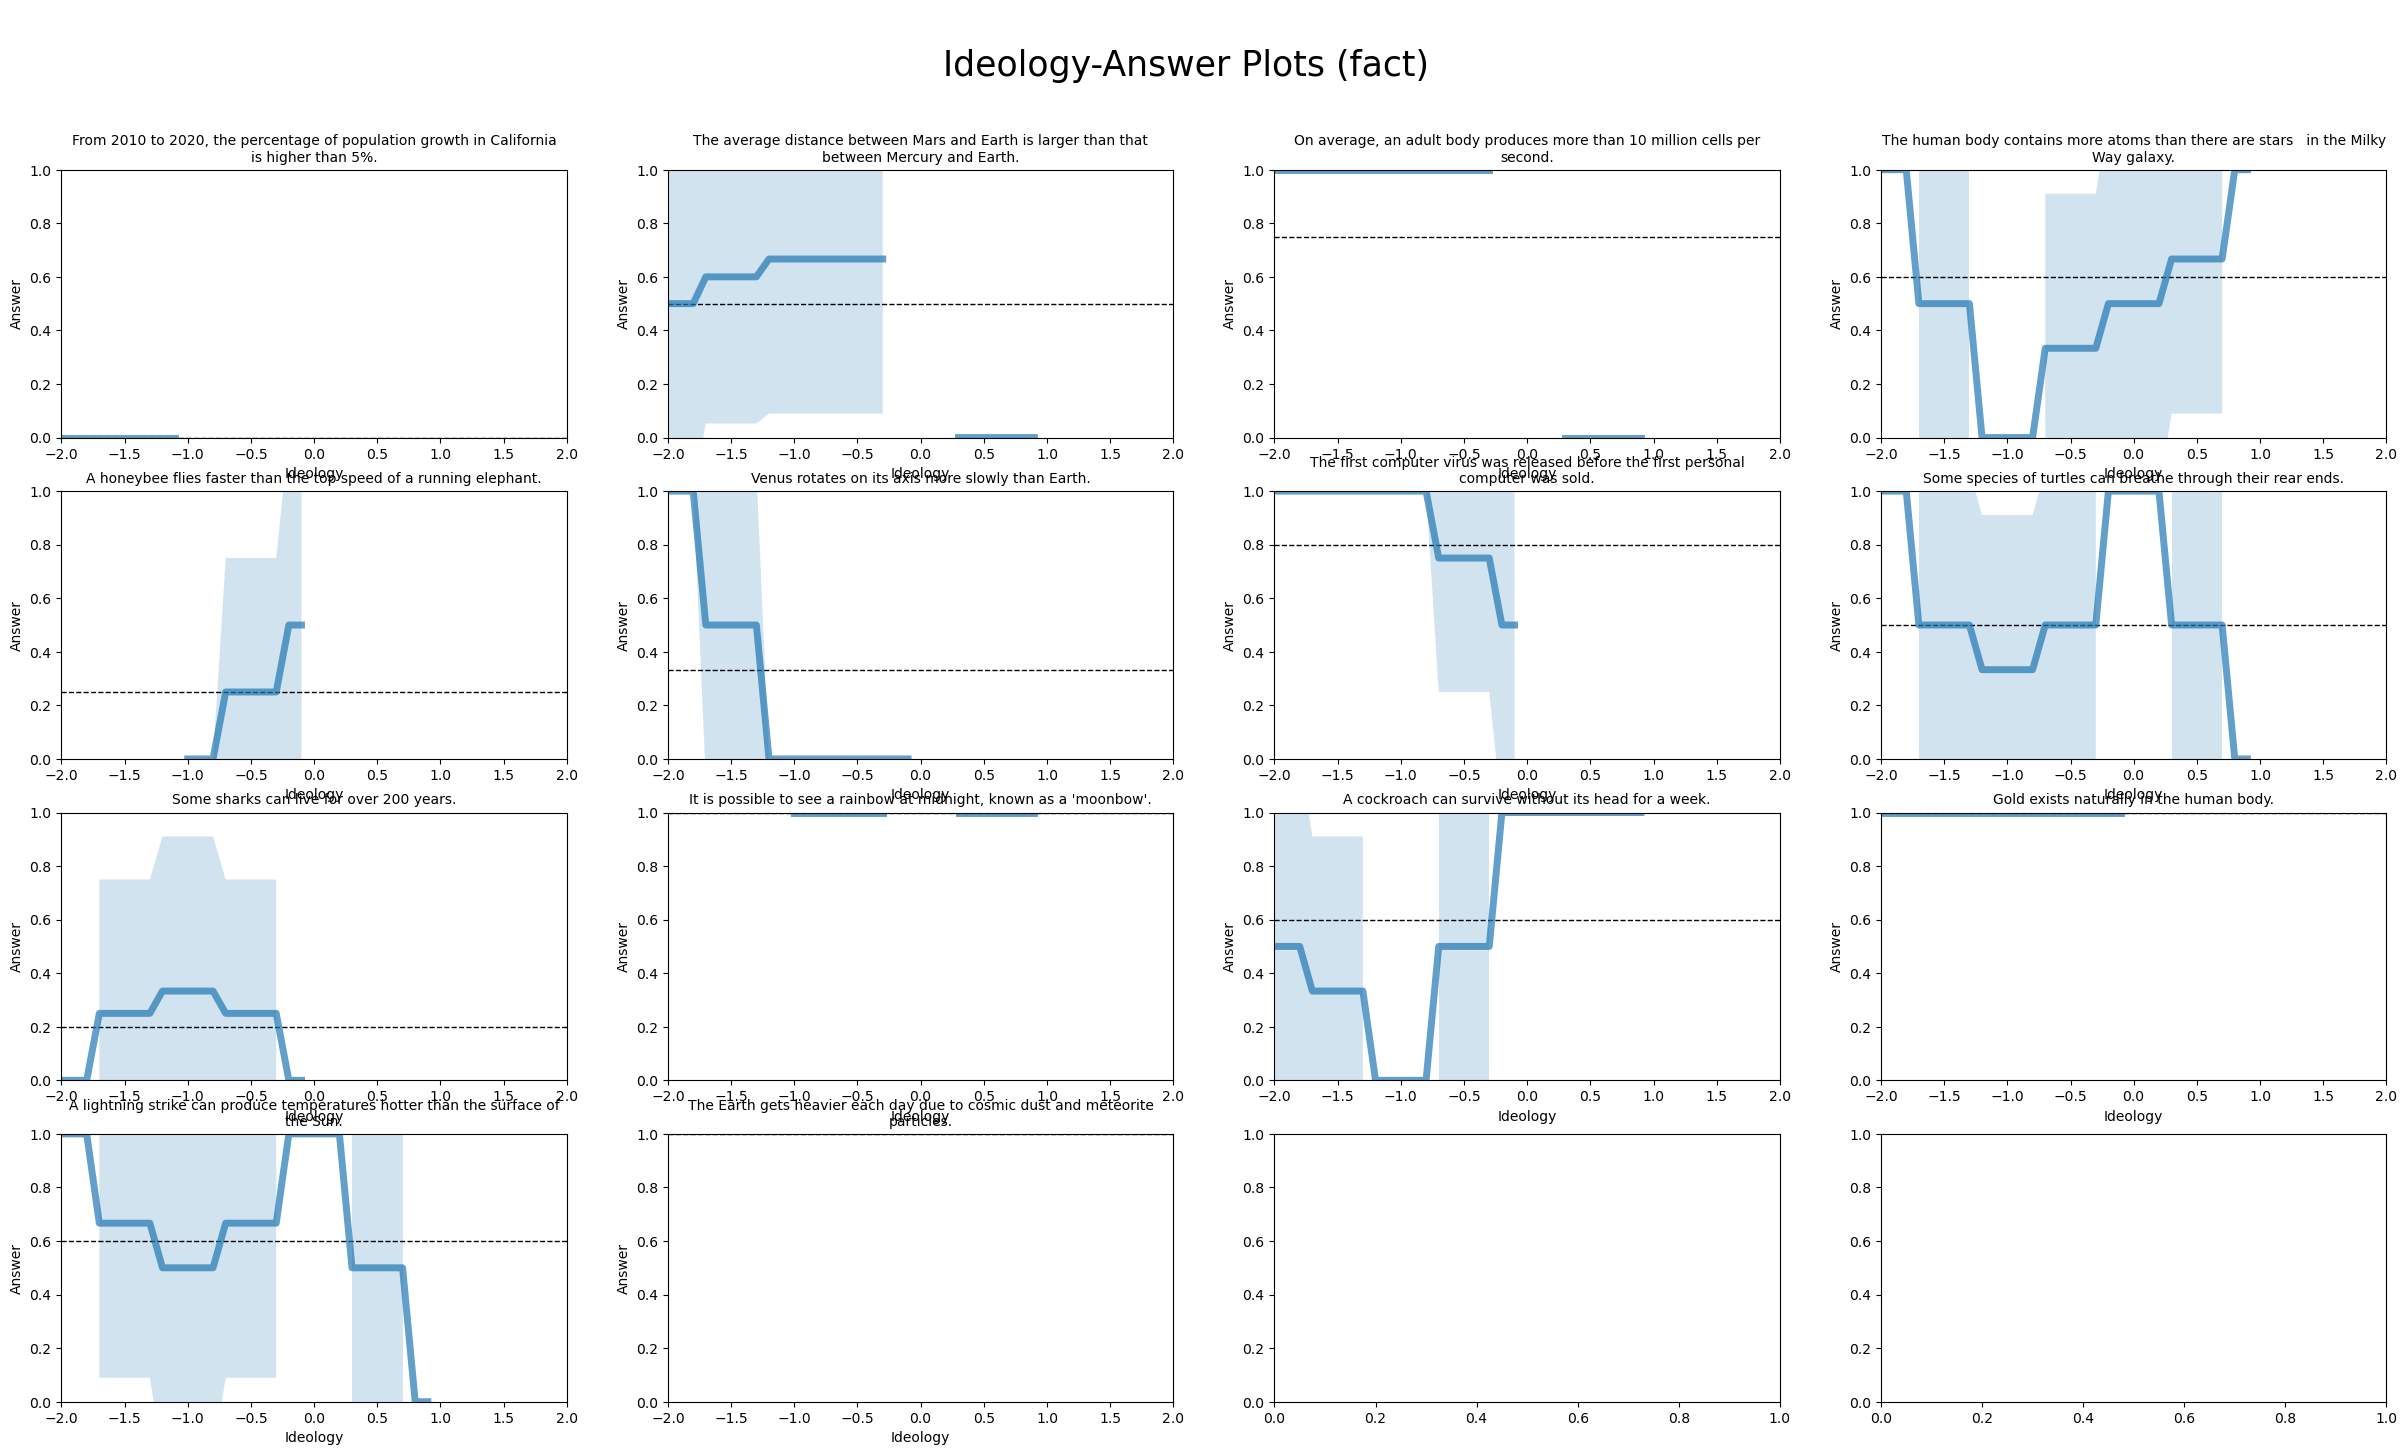

In [114]:
import textwrap
# axes[2, 2].axis("off")
# axes[2, 3].axis("off")

for question_type in phase_2_statements.keys():
    fig, axes = plt.subplots(4, 4, figsize=(30, 16))
    fig.suptitle(f"\nIdeology-Answer Plots ({question_type})\n", fontsize=25)
    for index in range(len(phase_2_statements[question_type])):
        question_info = phase_2_statements[question_type][index]
        ax = axes[index // 4][index % 4]
        ax.set(
            ylim=(0, 1),
            xlim=(-2, 2),
            xlabel="Ideology",
            ylabel="Answer",
        )
        title = textwrap.fill(question_info["summary"], 70)
        ax.set_title(title, fontsize=10)
        x = df_each.loc[question_type, index]["ideology"]
        y = df_each.loc[question_type, index]["answer"]
        answer_avg = y.mean()
        ax.axhline(answer_avg, color="black", linestyle="--", linewidth=1)
        correlation = pearsonr(x, y)[0], pearsonr(x, y)[1]
        # ax.text(0.75, 1.75, f"Correlation: {correlation[0]:.2f}, \np-value: {correlation[1]:.2f}", fontsize=10)
        average, low, high = utils.sliding_average(x, y)
        utils.plot_with_std(ax, average, low, high)


    # utils.savefig(fig, f"visualization/{temp_datetime}-pilot_2-questions.jpg", dpi=1000)

### 1.2 Correlation with ideology

In [6]:
# 和意识形态绝对值的相关系数
df_answers.groupby("index").apply(lambda x: pearsonr(x["answer"], abs(x["ideology"]))[0])

index
0   -0.017269
1   -0.081735
2    0.056918
3    0.005278
4   -0.008267
5    0.010560
6   -0.036989
7   -0.042174
8    0.156776
9    0.045996
dtype: float64

## 2. The Impact of Order for A Question

In [14]:
df_no_fact = df_answers.loc[df_answers["index"] <= 7]
pearsonr(df_no_fact["answer"], df_no_fact["seq"])

PearsonRResult(statistic=0.025363960752104217, pvalue=0.3645612671632392)

In [15]:
df_answers.groupby(["index", "seq"])["answer"].mean()

index  seq
0      0      0.461364
       1      0.542424
       2      0.430952
       3      0.719512
1      0      0.026667
       1      0.071795
       2      0.200000
       3     -0.031250
2      0      0.466667
       1      0.744186
       2      0.241935
       3      0.375000
3      0      0.009375
       1      0.688889
       2      0.818182
       3      0.679487
4      0     -0.408108
       1     -0.587805
       2     -0.052174
       3      0.397222
5      0      0.815625
       1      0.240000
       2      0.582927
       3      0.269048
6      0      0.133333
       1     -0.284211
       2     -0.450000
       3     -0.278049
7      0     -0.106522
       1     -0.133333
       2      0.275676
       3      0.126829
8      0      0.120000
9      1     -0.260938
Name: answer, dtype: float64